<a href="https://colab.research.google.com/github/TianyiRnj/dino-classification-extent/blob/PTDQ/Original_classification_with_dinov2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision pandas numpy matplotlib tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.0 MB/s eta 0:00:00


In [ ]:
!pip install torchinfo --quiet

In [ ]:
!pip install datasets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.3 MB/s eta 0:00:00


In [ ]:
#!/bin/bash
!kaggle datasets download andrewmvd/isic-2019
!unzip -q isic-2019.zip

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/isic-2019
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 9.09G/9.10G [04:08<00:00, 36.9MB/s]
100% 9.10G/9.10G [04:08<00:00, 39.3MB/s]


In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from PIL import Image

In [ ]:
# --- Step 2: Organize Data ---
# Load metadata
train_meta = pd.read_csv('ISIC_2019_Training_GroundTruth.csv')
train_meta['image'] = train_meta['image'] + '.jpg'

# Convert one-hot encoding to class labels
classes = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']
train_meta['label'] = train_meta[classes].idxmax(axis=1)
label_to_idx = {cls: idx for idx, cls in enumerate(classes)}


In [ ]:
train_df, temp_df = train_test_split(train_meta, test_size=0.3,
                                    stratify=train_meta['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5,
                                  stratify=temp_df['label'], random_state=42)

# --- Step 3: Define Dataset Class ---
class ISIC2019Dataset(Dataset):
    def __init__(self, df, img_dir='ISIC_2019_Training_Input/ISIC_2019_Training_Input', transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.label_to_idx = label_to_idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx]['image'])
        image = Image.open(img_path).convert('RGB')
        label = self.label_to_idx[self.df.iloc[idx]['label']]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# --- Step 4: Data Transforms and Loaders ---
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets and loaders
batch_size = 64
train_dataset = ISIC2019Dataset(train_df, transform=train_transform)
val_dataset = ISIC2019Dataset(val_df, transform=val_transform)
test_dataset = ISIC2019Dataset(test_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# --- Step 6: Model Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Step 5: Handle Class Imbalance ---
train_labels = [label for _, label in train_dataset]
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [ ]:
import torchvision.models as models
from torchsummary import summary

class DINOv2Classifier(nn.Module):
    def __init__(self, num_classes=8, pretrain_choice='frozen'):
        super().__init__()
        self.dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

        self.classifier = nn.Sequential(
            nn.Linear(self.dinov2.embed_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Get all image features (batch_size, num_patches, embed_dim)
        features = self.dinov2(x)
        features = self.dinov2.norm(features)

        # Handle different output formats:
        if features.dim() == 3:  # Standard case with spatial dimensions
            cls_token = features[:, 0, :]  # Extract [CLS] token

        else:  # Fallback for 2D output
            cls_token = features

        out = self.classifier(cls_token)
        return out

# model = DINOv2Classifier().to(device)
model = DINOv2Classifier(pretrain_choice='frozen').to(device)
summary(model, input_size=(3, 224, 224))

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 118MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 16, 16]         226,176
          Identity-2             [-1, 256, 384]               0
        PatchEmbed-3             [-1, 256, 384]               0
         LayerNorm-4             [-1, 257, 384]             768
            Linear-5            [-1, 257, 1152]         443,520
           Dropout-6          [-1, 6, 257, 257]               0
            Linear-7             [-1, 257, 384]         147,840
           Dropout-8             [-1, 257, 384]               0
   MemEffAttention-9             [-1, 257, 384]               0
       LayerScale-10             [-1, 257, 384]               0
        LayerNorm-11             [-1, 257, 384]             768
           Linear-12            [-1, 257, 1536]         591,360
             GELU-13            [-1, 257, 1536]               0
          Dropout-14            [-1, 25

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-6, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

In [ ]:
num_epochs = 25
best_val_acc = 0.0

# Lists to store metrics for plotting
train_losses = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', leave=True)

    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_loop.set_postfix({'loss': f"{loss.item():.4f}"})

    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    val_loop = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]', leave=True)

    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            val_loop.set_postfix({
                'loss': f"{loss.item():.4f}",
                'acc': f"{correct/total:.4f}"
            })

    val_loss /= len(val_loader.dataset)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_dinov2_isic2019.pth')
        print(f"\nNew best model saved with val acc: {val_acc:.4f}")

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/25 [Train]:   0%|          | 0/278 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/25 [Val]: 100%|██████████| 60/60 [01:01<00:00,  1.03s/it, loss=1.6919, acc=0.5432]



New best model saved with val acc: 0.5432

Epoch 1 Summary:
Train Loss: 1.8505 | Val Loss: 1.4987 | Val Acc: 0.5432


Epoch 2/25 [Val]: 100%|██████████| 60/60 [00:59<00:00,  1.00it/s, loss=1.4811, acc=0.6234]



New best model saved with val acc: 0.6234

Epoch 2 Summary:
Train Loss: 1.4538 | Val Loss: 1.2576 | Val Acc: 0.6234


Epoch 3/25 [Val]: 100%|██████████| 60/60 [00:58<00:00,  1.03it/s, loss=1.3353, acc=0.6208]



Epoch 3 Summary:
Train Loss: 1.2701 | Val Loss: 1.1250 | Val Acc: 0.6208


Epoch 4/25 [Val]: 100%|██████████| 60/60 [00:58<00:00,  1.03it/s, loss=1.3261, acc=0.6355]



New best model saved with val acc: 0.6355

Epoch 4 Summary:
Train Loss: 1.1720 | Val Loss: 1.0650 | Val Acc: 0.6355


Epoch 5/25 [Val]: 100%|██████████| 60/60 [00:58<00:00,  1.03it/s, loss=1.2449, acc=0.6442]



New best model saved with val acc: 0.6442

Epoch 5 Summary:
Train Loss: 1.1121 | Val Loss: 0.9788 | Val Acc: 0.6442


Epoch 6/25 [Val]: 100%|██████████| 60/60 [00:58<00:00,  1.02it/s, loss=1.2708, acc=0.6524]



New best model saved with val acc: 0.6524

Epoch 6 Summary:
Train Loss: 1.0351 | Val Loss: 0.9630 | Val Acc: 0.6524


Epoch 7/25 [Val]: 100%|██████████| 60/60 [01:00<00:00,  1.01s/it, loss=1.1327, acc=0.6845]



New best model saved with val acc: 0.6845

Epoch 7 Summary:
Train Loss: 1.0046 | Val Loss: 0.9268 | Val Acc: 0.6845


Epoch 8/25 [Val]: 100%|██████████| 60/60 [00:58<00:00,  1.02it/s, loss=1.2041, acc=0.6534]



Epoch 8 Summary:
Train Loss: 0.9371 | Val Loss: 0.8971 | Val Acc: 0.6534


Epoch 9/25 [Val]: 100%|██████████| 60/60 [00:58<00:00,  1.02it/s, loss=1.1420, acc=0.6837]



Epoch 9 Summary:
Train Loss: 0.9042 | Val Loss: 0.8655 | Val Acc: 0.6837


Epoch 10/25 [Val]: 100%|██████████| 60/60 [00:58<00:00,  1.03it/s, loss=1.1778, acc=0.6768]



Epoch 10 Summary:
Train Loss: 0.8801 | Val Loss: 0.8942 | Val Acc: 0.6768


Epoch 11/25 [Val]: 100%|██████████| 60/60 [00:58<00:00,  1.03it/s, loss=0.9732, acc=0.6842]



Epoch 11 Summary:
Train Loss: 0.8188 | Val Loss: 0.8675 | Val Acc: 0.6842


Epoch 12/25 [Val]: 100%|██████████| 60/60 [00:59<00:00,  1.01it/s, loss=1.1007, acc=0.6871]



New best model saved with val acc: 0.6871

Epoch 12 Summary:
Train Loss: 0.8086 | Val Loss: 0.8113 | Val Acc: 0.6871


Epoch 13/25 [Val]: 100%|██████████| 60/60 [01:00<00:00,  1.01s/it, loss=0.9353, acc=0.7121]



New best model saved with val acc: 0.7121

Epoch 13 Summary:
Train Loss: 0.7941 | Val Loss: 0.8026 | Val Acc: 0.7121


Epoch 14/25 [Val]: 100%|██████████| 60/60 [00:58<00:00,  1.02it/s, loss=0.8330, acc=0.7200]



New best model saved with val acc: 0.7200

Epoch 14 Summary:
Train Loss: 0.7682 | Val Loss: 0.8486 | Val Acc: 0.7200


Epoch 15/25 [Val]: 100%|██████████| 60/60 [00:58<00:00,  1.02it/s, loss=0.8312, acc=0.6987]



Epoch 15 Summary:
Train Loss: 0.7561 | Val Loss: 0.8152 | Val Acc: 0.6987


Epoch 16/25 [Val]: 100%|██████████| 60/60 [00:57<00:00,  1.04it/s, loss=0.9385, acc=0.7058]



Epoch 16 Summary:
Train Loss: 0.7265 | Val Loss: 0.7754 | Val Acc: 0.7058


Epoch 17/25 [Val]: 100%|██████████| 60/60 [00:58<00:00,  1.03it/s, loss=0.8211, acc=0.7479]



New best model saved with val acc: 0.7479

Epoch 17 Summary:
Train Loss: 0.7096 | Val Loss: 0.7664 | Val Acc: 0.7479


Epoch 18/25 [Val]: 100%|██████████| 60/60 [00:58<00:00,  1.03it/s, loss=0.7675, acc=0.7321]



Epoch 18 Summary:
Train Loss: 0.7216 | Val Loss: 0.7714 | Val Acc: 0.7321


Epoch 19/25 [Val]: 100%|██████████| 60/60 [00:58<00:00,  1.03it/s, loss=0.7914, acc=0.7545]



New best model saved with val acc: 0.7545

Epoch 19 Summary:
Train Loss: 0.6785 | Val Loss: 0.7433 | Val Acc: 0.7545


Epoch 20/25 [Val]: 100%|██████████| 60/60 [00:59<00:00,  1.01it/s, loss=0.7469, acc=0.7289]



Epoch 20 Summary:
Train Loss: 0.6958 | Val Loss: 0.7753 | Val Acc: 0.7289


Epoch 21/25 [Val]: 100%|██████████| 60/60 [00:59<00:00,  1.01it/s, loss=0.7678, acc=0.7513]



Epoch 21 Summary:
Train Loss: 0.6485 | Val Loss: 0.7462 | Val Acc: 0.7513


Epoch 22/25 [Val]: 100%|██████████| 60/60 [00:58<00:00,  1.03it/s, loss=0.7075, acc=0.7524]



Epoch 22 Summary:
Train Loss: 0.6395 | Val Loss: 0.7214 | Val Acc: 0.7524


Epoch 23/25 [Val]: 100%|██████████| 60/60 [00:58<00:00,  1.03it/s, loss=0.6809, acc=0.7461]



Epoch 23 Summary:
Train Loss: 0.6295 | Val Loss: 0.7445 | Val Acc: 0.7461


Epoch 24/25 [Val]: 100%|██████████| 60/60 [00:58<00:00,  1.03it/s, loss=0.5879, acc=0.7566]



New best model saved with val acc: 0.7566

Epoch 24 Summary:
Train Loss: 0.6417 | Val Loss: 0.7665 | Val Acc: 0.7566


Epoch 25/25 [Val]: 100%|██████████| 60/60 [00:58<00:00,  1.03it/s, loss=0.6029, acc=0.7500]


Epoch 25 Summary:
Train Loss: 0.5879 | Val Loss: 0.7366 | Val Acc: 0.7500


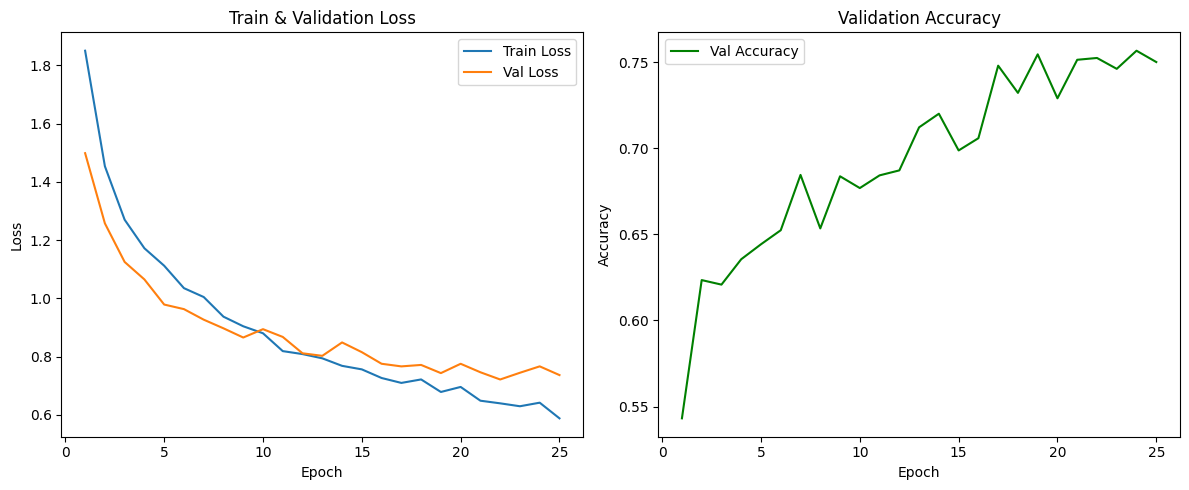

In [ ]:
import matplotlib.pyplot as plt

# Plotting the metrics after training
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Train and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train & Validation Loss')
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accs, label='Val Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# --- Step 9: Final Evaluation ---
model.load_state_dict(torch.load('best_dinov2_isic2019.pth'))
model.eval()
test_correct = 0
test_total = 0
test_loop = tqdm(test_loader, desc='Testing', leave=True)

with torch.no_grad():
    for images, labels in test_loop:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        test_loop.set_postfix({'acc': f"{test_correct/test_total:.4f}"})

test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

<ipython-input-14-f1790a0a500c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_dinov2_isic2019.pth'))
Testing: 100%|██████████| 60/6


Final Test Accuracy: 0.7532
